# Long-short strategy

Trades with multiple assets

In [1]:
import epymetheus

import pandas as pd
from pandas_datareader.data import DataReader
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
try:
    import seaborn
    seaborn.set_style('ticks')
except ImportError:
    pass
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from epymetheus import Universe, Trade, TradeStrategy

/usr/local/lib/python3.8/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [4]:
from epymetheus.datasets import fetch_usstocks

universe = fetch_usstocks(n_assets=10)
universe.prices

Fetching AAPL (1/10) ...
Fetching MSFT (2/10) ...
Fetching AMZN (3/10) ...
Fetching BRK-A (4/10) ...
Fetching JPM (5/10) ...
Fetching JNJ (6/10) ...
Fetching WMT (7/10) ...
Fetching BAC (8/10) ...
Fetching PG (9/10) ...
Fetching XOM (10/10) ...
Done.


,AAPL,MSFT,AMZN,BRK-A,JPM,JNJ,WMT,BAC,PG,XOM
2000-01-01,3.187337,37.453701,76.125000,56100.0,28.151169,27.276423,47.794632,12.398399,29.213911,22.168360
2000-01-02,3.187337,37.453701,76.125000,56100.0,28.151169,27.276423,47.794632,12.398399,29.213911,22.168360
2000-01-03,3.470226,37.393559,89.375000,54800.0,26.407299,26.965630,46.195686,11.966080,28.580635,21.549223
2000-01-04,3.177650,36.130390,81.937500,52000.0,25.901106,25.978415,44.467136,11.255836,28.030689,21.136469
2000-01-05,3.224152,36.511333,69.750000,53200.0,25.741232,26.252653,43.559650,11.379356,27.497412,22.288738
...,...,...,...,...,...,...,...,...,...,...
2018-12-28,153.552979,98.657784,1478.020020,302600.0,92.339806,122.996414,89.903374,23.696262,88.162086,64.133499
2018-12-29,153.552979,98.657784,1478.020020,302600.0,92.339806,122.996414,89.903374,23.696262,88.162086,64.133499
2018-12-30,153.552979,98.657784,1478.020020,302600.0,92.339806,122.996414,89.903374,23.696262,88.162086,64.133499
2018-12-31,155.037109,99.817421,1501.969971,306000.0,93.093178,124.716644,90.898720,23.939152,88.877579,64.152336


In [16]:
class SimpleLongShort(TradeStrategy):
    """Simple long-short strategy."""
    def __init__(self, percentile, bet):
        self.percentile = percentile
        self.bet = bet
    
    def logic(self, universe):
        watch_period = DateOffset(months=1)
        trade_period = DateOffset(months=1)
        n_trade = int(universe.n_assets * self.percentile)

        def trade_open_dates(universe, watch_period, trade_period):
            """Yield begin_date of trades."""
            open_date = universe.bars[0] + watch_period
            while open_date + trade_period <= universe.bars[-1]:
                yield open_date
                open_date += trade_period

        def tot_returns(open_date):
            """Return 1 month return of assets as Series."""
            b = open_date - DateOffset(days=1)
            e = open_date - DateOffset(months=1)
            return universe.prices.loc[e, :] / universe.prices.loc[b, :]

        for open_date in trade_open_dates(universe, watch_period, trade_period):
            shut_date = open_date + trade_period
            r = tot_returns(open_date)
            assets_sorted = sorted(universe.assets, key=lambda asset: r[asset])

            for asset_l, asset_s in zip(assets_sorted[-n_trade:], assets_sorted[:n_trade]):
                lot_l = +self.bet / universe.prices.at[open_date, asset_l]
                lot_s = -self.bet / universe.prices.at[open_date, asset_s]
                yield Trade(
                    asset=[asset_l, asset_s], 
                    lot=[lot_l, lot_s],
                    open_bar=open_date,
                    shut_bar=shut_date,
                )

In [27]:
strategy = SimpleLongShort(percentile=0.2, bet=10000)

In [28]:
strategy.run(universe)

Running ... 


Generating 454 trades (2018-12-01 00:00:00) ... Done. (Runtime : 0.42 sec)


Executing 454 trades ... Done. (Runtime : 0.56 sec)
Done. (Runtime : 0.98 sec)


In [29]:
history = strategy.history.to_dataframe()
# transaction = pd.DataFrame(strategy.transaction).set_index('bars')
wealth = strategy.wealth.to_dataframe()

Evaluating history     ... Done. (Runtime : 0.03 sec)
Evaluating wealth      ... Done. (Runtime : 0.25 sec)


In [30]:
history.head()

,trade_id,asset,lot,open_bar,close_bar,shut_bar,take,stop,pnl
order_id,,,,,,,,,
0,0,MSFT,302.822791,2000-02-01,2000-03-01,2000-03-01,None,None,-1177.900766
1,0,JPM,-326.730603,2000-02-01,2000-03-01,2000-03-01,None,None,208.954705
2,1,WMT,246.439657,2000-02-01,2000-03-01,2000-03-01,None,None,-1650.692768
3,1,XOM,-436.859122,2000-02-01,2000-03-01,2000-03-01,None,None,753.418836
4,2,BRK-A,0.223714,2000-03-01,2000-04-01,2000-04-01,None,None,2796.420582


In [31]:
# transaction.head()

In [32]:
wealth.tail()

,wealth
bars,
2018-12-28,10409.355328
2018-12-29,10409.355328
2018-12-30,10409.355328
2018-12-31,10416.344561
2019-01-01,10416.344561


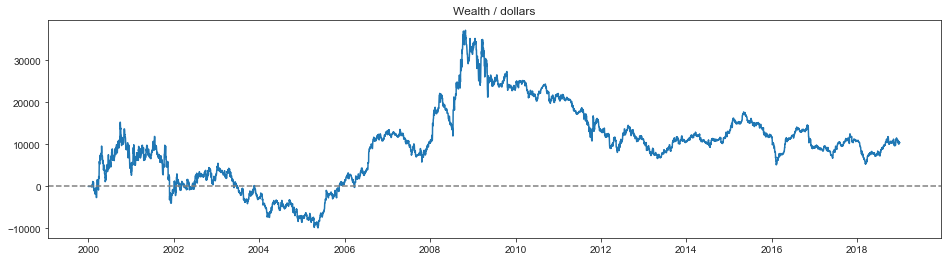

In [33]:
plt.figure(figsize=(16, 4))
plt.plot(wealth)
plt.axhline(0, color='gray', ls='--')
plt.title('Wealth / dollars')
plt.show()

In [35]:
# net_exposure = (transaction.cumsum() * universe.prices).sum(axis=1)
# abs_exposure = (transaction.cumsum().applymap(abs) * universe.prices).sum(axis=1)

# plt.figure(figsize=(16, 8))

# plt.subplot(2, 1, 1)
# plt.plot(net_exposure)
# plt.axhline(0, color='gray', ls='--')
# plt.title('Net exposure / dollars')

# plt.subplot(2, 1, 2)
# plt.plot(abs_exposure)
# plt.axhline(0, color='gray', ls='--')
# plt.title('Abs exposure / dollars')

# plt.show()

In [37]:
gains = history.pnl
gains_agg = history[['trade_index', 'gains']].groupby('trade_index').agg('sum')

plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.hist(gains_agg.values, bins=50)
plt.axvline(0, color='red', ls='--')
plt.title('Gain of each long-short position')

plt.subplot(1, 2, 2)
plt.hist(gains, bins=50)
plt.axvline(0, color='red', ls='--')
plt.title('Gain of each order')

plt.show()

KeyError: "None of [Index(['trade_index', 'gains'], dtype='object')] are in the [columns]"